<a href="https://colab.research.google.com/github/Ademola-Olorunnisola/TB-Estimator/blob/main/Empirical_nonlinear_observability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy

In [ ]:

try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

### Import plotting utilities and planar drone locally or from github

Fetching from: 
<Response [200]>
State names : ['S', 'V', 'E', 'I', 'T', 'R', 'beta', 'eps', 'gamma', 'sigma', 'phi', 'rho']
Measurement names (IVR)    : ['I', 'V', 'R']
Measurement names (IVRET)  : ['I', 'V', 'R', 'E', 'T']

R0 = 0.2974


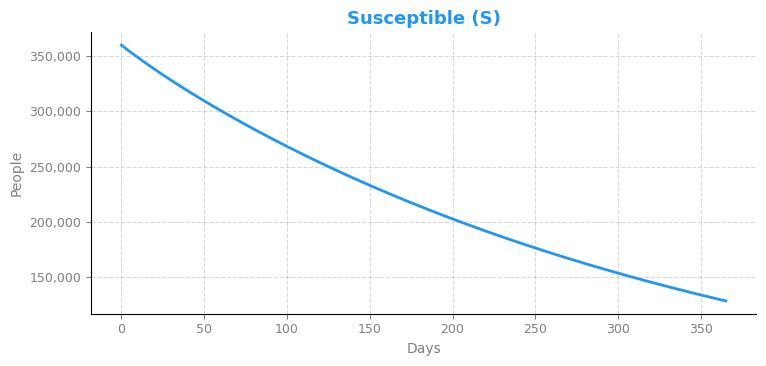

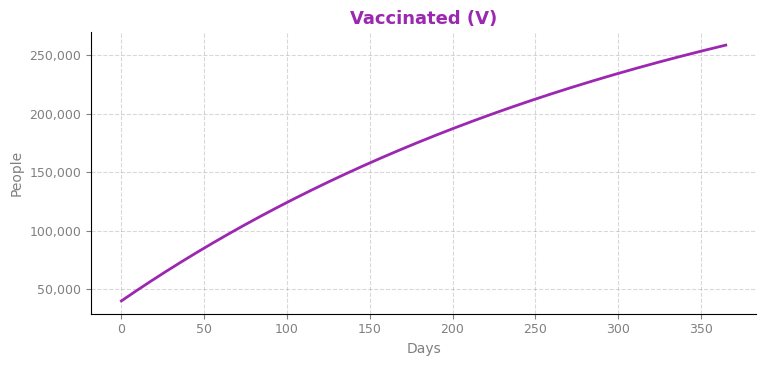

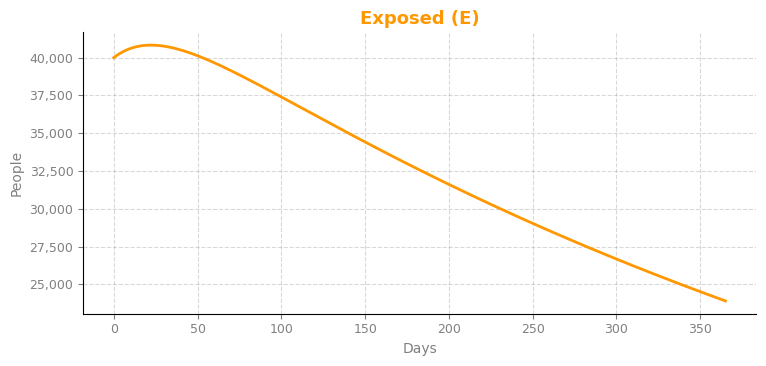

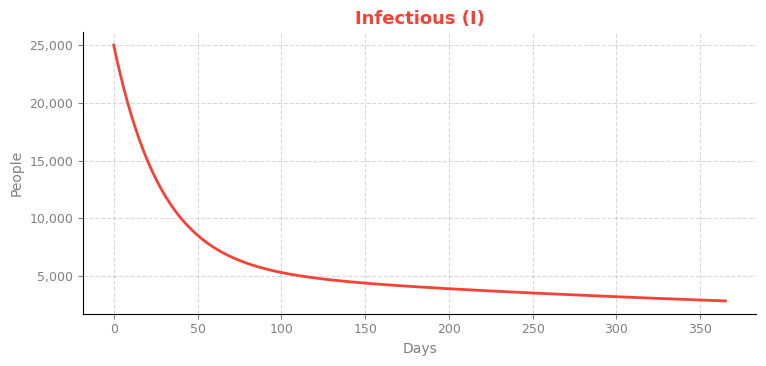

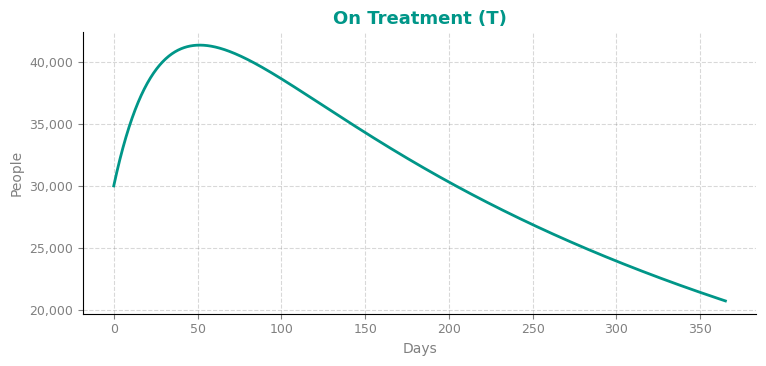

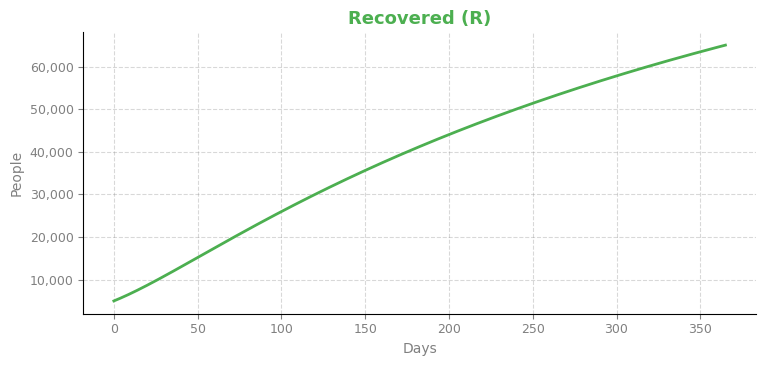

In [12]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/Ademola-Olorunnisola/TB-Estimator/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

tb_simulations = import_local_or_github('model_simulation2', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')

# TB DYNAMICS


$$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) = \mathbf{f_0}(\mathbf{x}) + \mathbf{f_1}(\mathbf{x})\bbox[lightgreen]{\alpha} + \mathbf{f_2}(\mathbf{x})\bbox[lightgreen]{\kappa}
$$

$$
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{S} \\[0.3em]
\bbox[yellow]{V} \\[0.3em]
\bbox[yellow]{I} \\[0.3em]
\bbox[yellow]{R} \\[0.3em]
\bbox[pink]{\beta} \\[0.3em]
\bbox[pink]{\sigma}
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[lightblue]{\Lambda} - \bbox[pink]{\beta}\bbox[yellow]{SI} - \bbox[lightblue]{\mu}\bbox[yellow]{S} \\[0.3em]
0 - \bbox[pink]{\sigma}\bbox[pink]{\beta}\bbox[yellow]{VI} - \bbox[lightblue]{\mu}\bbox[yellow]{V} \\[0.3em]
\bbox[pink]{\beta}\bbox[yellow]{SI} + \bbox[pink]{\sigma}\bbox[pink]{\beta}\bbox[yellow]{VI} - \bbox[lightblue]{\gamma}\bbox[yellow]{I} - \bbox[lightblue]{\mu}\bbox[yellow]{I} \\[0.3em]
\bbox[lightblue]{\gamma}\bbox[yellow]{I} - \bbox[lightblue]{\mu}\bbox[yellow]{R}\\[0.3em]
0\\[0.3em]
0
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
-\bbox[yellow]{S} \\[0.3em]
\bbox[yellow]{S} \\[0.3em]
0 \\[0.3em]
0\\[0.3em]
0\\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{\alpha} +
\overset{f_2}{\begin{bmatrix}
\bbox[pink]{\beta}\bbox[yellow]{SI} \\[0.3em]
\bbox[pink]{\sigma}\bbox[pink]{\beta}\bbox[yellow]{VI} \\[0.3em]
-\bbox[pink]{\beta}\bbox[yellow]{SI} - \bbox[pink]{\sigma}\bbox[pink]{\beta}\bbox[yellow]{VI} \\[0.3em]
0\\[0.3em]
0\\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{\kappa}
$$

# Dynamics and measurement functions

In [15]:
h_a = tb_simulations.H('observe_IVR').h
h_b = tb_simulations.H('observe_IVRЕТ').h
h_c = tb_simulations.H('observe_I').h


In [16]:
f = tb_simulations.F().f
h = h_b

In [ ]:
def u_func(x_vec, t):
    """vaccination and Treatment rate"""
    I = x_vec[2]
    alpha = 1 / 365
    tau = 1 / 30
    return np.array([alpha, tau])

In [ ]:
def f_ode(x_vec, t):
    """Wrapper for odeint"""
    u_vec = u_func(x_vec, t)
    return f(x_vec, u_vec)


In [ ]:
N = 223000000
x0 = np.array([
    0.8,     # S: 0.6726 (67.26%)
    0.1,      # V: 0.1000 (10.00%)
    0.1794,      # I: 0.1794 (17.94%) - MUCH HIGHER infected population
    0.048,      # R: 0.0480 (4.80%)
    0.05,         # beta: realistic TB transmission (slow)
    0.00275          # sigma
])

# Run simulation

In [ ]:
t_sim = np.arange(0, 200, 1.0)
result = odeint(f_ode, x0, t_sim)


In [ ]:
x_sim = {
    'S': result[:, 0],
    'V': result[:, 1],
    'I': result[:, 2],
    'R': result[:, 3],
    'beta': result[:, 4],
    'sigma': result[:, 5]
}

In [ ]:
u_sim = {'alpha': [], 'kappa': []}
for i in range(len(t_sim)):
    u = u_func(result[i], t_sim[i])
    u_sim['alpha'].append(u[0])
    u_sim['kappa'].append(u[1])

In [ ]:
y_sim_absolute = {
    'S_absolute': x_sim['S'] * N,
    'V_absolute': x_sim['V'] * N,
    'I_absolute': x_sim['I'] * N,
    'R_absolute': x_sim['R'] * N,
    'beta': x_sim['beta'],
    'sigma': x_sim['sigma']
}

### Define measurement noise characteritics for each measurement option in the measurement set

In [ ]:
measurement_noise_stds = {
    'S_absolute': 100000.0,
    'I_absolute': 10000.0,
    'V_absolute': 100000.0,
    'R_absolute': 5000.0,
    'beta': 1e-8,
    'sigma': 1e-8
}

In [ ]:
# Add noise
np.random.seed(42)
y_noisy_absolute = {
    key: y_sim_absolute[key] + np.random.normal(0, measurement_noise_stds[key], len(t_sim))
    for key in y_sim_absolute.keys()
}

In [ ]:
y_noisy = {key: y_noisy_absolute[key] / N for key in y_noisy_absolute.keys()}

### Plot the infected population over time

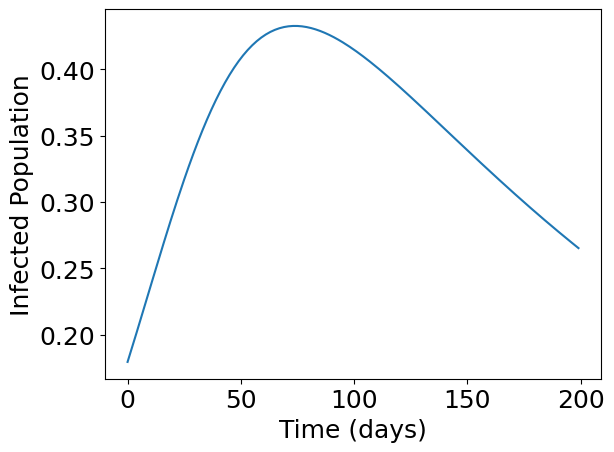

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t_sim, x_sim['I'])
ax.set_xlabel('Time (days)')
ax.set_ylabel('Infected Population')
plt.show()

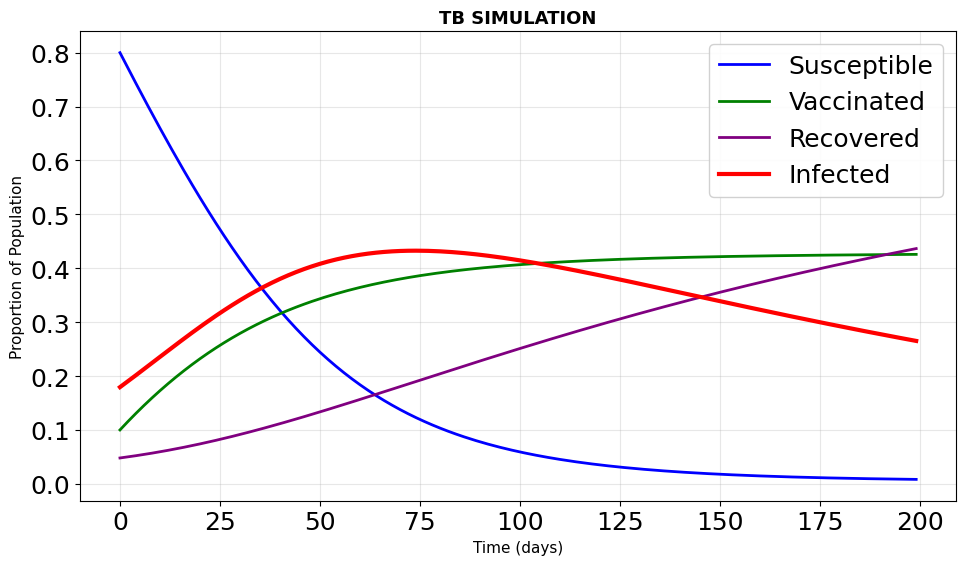

In [ ]:
# TB Compartment Dynamics - CORRECTED
plt.figure(figsize=(10, 6))

# Plot proportions directly (no incorrect scaling)
plt.plot(t_sim, result[:,0], 'b-', linewidth=2, label='Susceptible')
plt.plot(t_sim, result[:,1], 'g-', linewidth=2, label='Vaccinated')
plt.plot(t_sim, result[:,3], 'purple', linewidth=2, label='Recovered')
plt.plot(t_sim, result[:,2], 'r-', linewidth=3, label='Infected')

plt.ylabel('Proportion of Population', fontsize=11)
plt.xlabel('Time (days)', fontsize=11)
plt.title('TB SIMULATION', fontsize=13, fontweight='bold')
plt.legend(loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Save data as dataframes

In [ ]:
x_sim_df = pd.DataFrame(x_sim)
y_noisy_df = pd.DataFrame(y_noisy)
u_sim_df = pd.DataFrame(u_sim)

# Pybound Simulator

In [ ]:
state_names = f(None, None, return_state_names=True)
input_names = ['alpha', 'kappa']
measurement_names = h(None, None, return_measurement_names=True)

In [ ]:
simulator = pybounds.Simulator(
    f,
    h,
    dt=1.0,
    state_names=state_names,
    input_names=input_names,
    measurement_names=measurement_names,
    mpc_horizon=10
)

#Observability analysis

In [ ]:
w = 7  # window size, set to None to use entire time-series as one window

### This is the computationally heavy step

Here we calculate the observability matrix for each sliding window, all the states, and measurements. Later we can subselect from this to choose specific time steps, measurements, states, etc. to consider.

In [ ]:
# Construct O in sliding windows
SEOM = pybounds.SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4)

# Get O's
O_sliding = SEOM.get_observability_matrix()

In [ ]:
n_window = len(O_sliding)
print(n_window, 'windows')

194 windows


### Look at one of the observability matrices

In [ ]:
O_sliding[0]

,,S,V,I,R,beta,sigma
sensor,time_step,,,,,,
S_absolute,0,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
V_absolute,0,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
I_absolute,0,0.000000,0.000000e+00,1.000000,0.000000e+00,0.000000,0.000000
R_absolute,0,0.000000,0.000000e+00,0.000000,1.000000e+00,0.000000,0.000000
S_absolute,1,0.981781,-3.832484e-07,-0.035889,3.175238e-10,-0.131085,-0.000015
V_absolute,1,0.009909,9.999345e-01,-0.000193,5.134781e-11,-0.000700,-0.000852
I_absolute,1,0.008244,2.285633e-05,1.030404,-3.880229e-10,0.131423,0.000865
R_absolute,1,0.000023,6.388959e-08,0.005634,9.999570e-01,0.000363,0.000002
S_absolute,2,0.963364,-1.568801e-06,-0.071521,6.866729e-10,-0.265840,-0.000061


### Convert a single observability matrix into fisher information

$F = \mathcal{O}_w^T R_w^{-1} \mathcal{O}_w$

In [ ]:
measurement_noise_vars = {key: val**2 for key, val in measurement_noise_stds.items()}

In [ ]:
# CORRECTED: Define measurement noise with std=1 (professor's recommendation)
# This automatically matches whatever measurements your h function returns
measurement_names = h(None, None, return_measurement_names=True)
measurement_noise_stds = {name: 1.0 for name in measurement_names}

# Convert to variances
measurement_noise_vars = {key: val**2 for key, val in measurement_noise_stds.items()}

# Now compute Fisher information
FO = pybounds.FisherObservability(SEOM.O_df_sliding[0], measurement_noise_vars, lam=1e-8)

In [ ]:
# Get the Fisher information, inverse, and R matrix
F, F_inv, R = FO.get_fisher_information()
F_inv

,S,V,I,R,beta,sigma
S,0.353769,-0.104105,-0.106041,0.000437,0.510475,-32.370895
V,-0.104105,0.326679,-0.079776,0.000491,-0.249646,60.367435
I,-0.106041,-0.079776,0.332864,-0.003355,-0.317232,-26.616340
R,0.000437,0.000491,-0.003355,0.142939,0.001786,0.163356
beta,0.510475,-0.249646,-0.317232,0.001786,1.348573,-81.150324
sigma,-32.370895,60.367435,-26.616340,0.163356,-81.150324,19846.073901


### Efficiently repeat the above process for a specific set of sensors, states, and time points

In [ ]:

# Choose sensors to use from O -- you can select a subset from the available measurements
o_sensors = h(None, None, return_measurement_names=True)  # ['I_absolute'] or ['I_absolute', 'R_absolute']

# Choose states to use from O
o_states = ['S', 'V', 'I', 'R', 'beta', 'sigma']

# Choose time-steps to use from O
window_size = 7  # this cannot be larger than what was defined above
o_time_steps = np.arange(0, window_size, step=1)

# Redefine R -- if you remove a sensor you need to change R
o_measurement_noise_vars = {key: measurement_noise_vars[key] for key in o_sensors}

In [ ]:
# Compute the Fisher information & inverse for each window and store the minimum error variance
SFO = pybounds.SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-8, R=o_measurement_noise_vars,
                                          states=o_states, sensors=o_sensors, time_steps=o_time_steps, w=None)

# If you want to manually inspect one of the fisher info matrices:
# SFO.FO[1].O

In [ ]:
# Pull out minimum error variance, 'time' column is the time vector shifted forward by w/2 and 'time_initial' is the original time
EV_aligned = SFO.get_minimum_error_variance()

In [ ]:
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

/tmp/ipython-input-1416315243.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')


# Plot observability over time

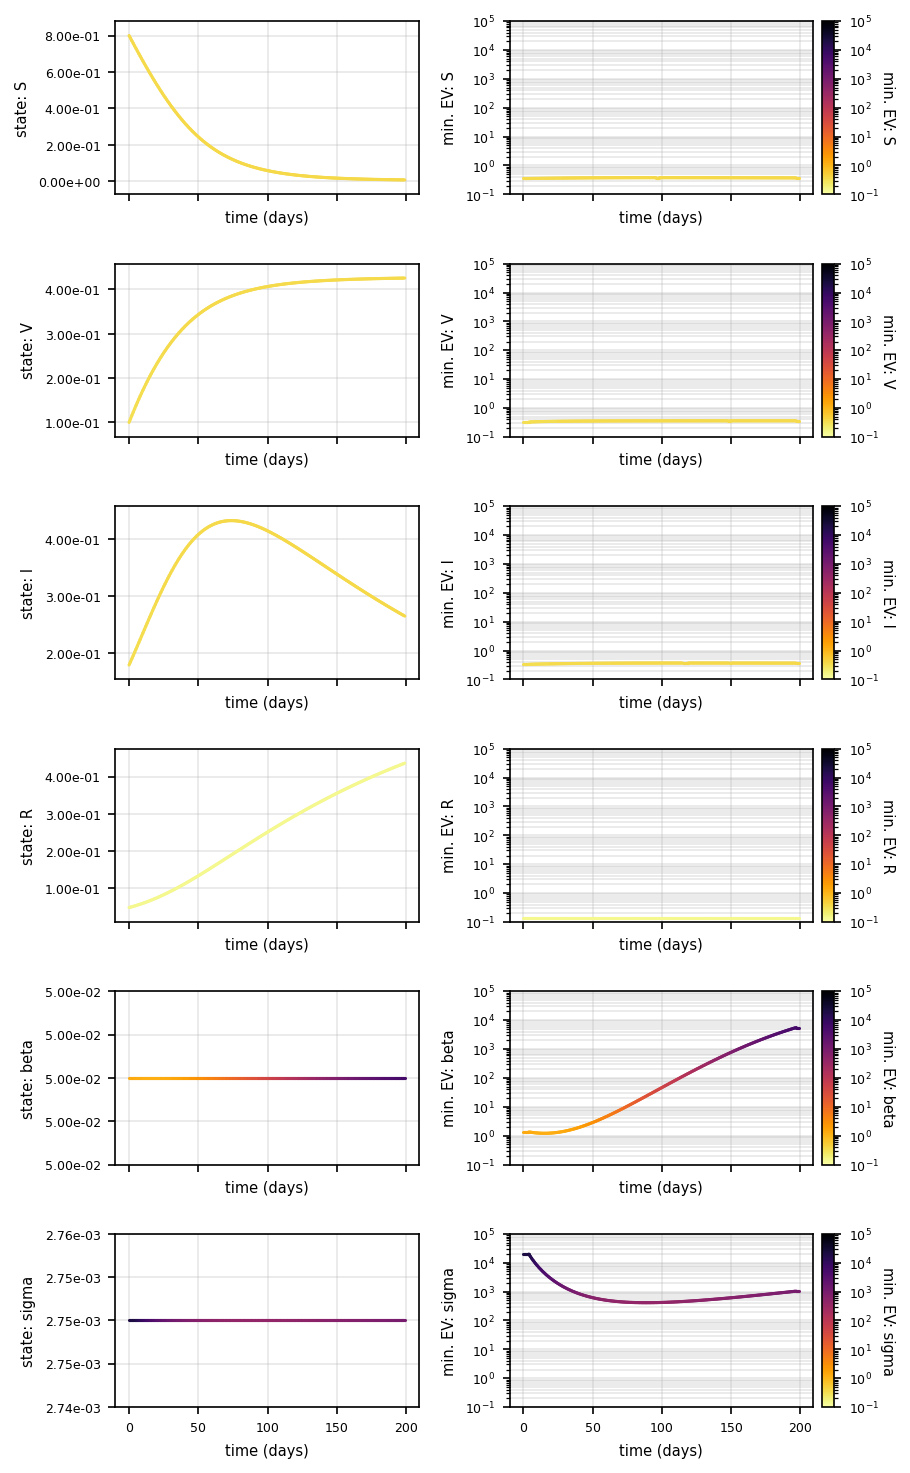

In [ ]:
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import numpy as np

states = list(SFO.FO[0].O.columns)
n_state = len(states)
fig, ax = plt.subplots(n_state, 2, figsize=(6, n_state*2), dpi=150, sharex=True)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'
min_ev = np.min(EV_no_nan.iloc[:, 2:].values)
max_ev = np.max(EV_no_nan.iloc[:, 2:].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

# Formatter for scientific notation
def fmt(x, pos):
    return f'{x:.2e}'

for n, state_name in enumerate(states):
    # Left panel: state trajectory
    pybounds.colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values,
                       ax=ax[n, 0], cmap=cmap, norm=cnorm)

    # Right panel: eigenvalues
    pybounds.colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values,
                       ax=ax[n, 1], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high,
                                         log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    # IMPROVED: Better y-axis limits for left panel
    x_vals = x_sim[state_name]
    x_range = np.max(x_vals) - np.min(x_vals)

    if x_range < 1e-4:  # Very small changes (like I, R, beta, sigma)
        # Use tighter limits to show variation
        x_mean = np.mean(x_vals)
        padding = max(x_range * 0.5, 1e-5)  # At least some padding
        ax[n, 0].set_ylim(x_mean - padding, x_mean + padding)
    else:  # Larger changes (like S, V)
        x_max = np.max(x_vals)
        x_min = np.min(x_vals)
        padding = x_range * 0.1
        ax[n, 0].set_ylim(x_min - padding, x_max + padding)

    ax[n, 0].set_ylabel('state: ' + state_name, fontsize=7)
    ax[n, 0].yaxis.set_major_formatter(FuncFormatter(fmt))
    ax[n, 0].grid(True, alpha=0.3)

    # Right panel formatting
    ax[n, 1].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 1].set_yticks(np.logspace(log_tick_low, log_tick_high,
                                    log_tick_high-log_tick_low + 1))
    ax[n, 1].grid(True, alpha=0.3, which='both')

# Final formatting
for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    a.set_xlabel('time (days)', fontsize=7)
    offset = t_sim[-1] * 0.05
    a.set_xlim(-offset, t_sim[-1] + offset)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
plt.show()

# Exercises:

1. Change the measurements to one of the other options listed at the top. What changes for the observability?
2. Change the noise characteristics, how does this change the observability?